# Race Studio 3 Data Processing

## Initial Configuration

In [1]:
import pint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

u = pint.UnitRegistry()
Q_ = u.Quantity
u.define('percent = pct = dimensionless / 100')
u.define('gear = dimensionless')

## Initialize Race Data from Spreadsheet

This code takes formatted race data from a `.csv` file and parses it into [`Pandas Dataframes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and [`Pint`](https://pint.readthedocs.io/en/stable/) Unit objects so that computations can be easily performed on the data.

In [2]:
RACE_DATA_FILEPATH = "data/formatted/BETTER_20230831_143833_Blair Hosie_Rush SR 150_Palmer ACW_a_0045.csv"
UNITS = {}

def generate_units_dict(csv_filepath: str) -> dict[str, str]:
    units_data = pd.read_csv(
        filepath_or_buffer=csv_filepath,
        nrows=1,
    ).to_dict(orient='list')
    for unit, label in units_data.items():
        if unit.replace(' ', '') == '':
            unit = 'dimensionless'
        UNITS[label[0]] = unit.replace(' ', '').replace('%', 'percent')
    return UNITS


def assign_df_units(df: pd.DataFrame | pd.Series, units: str) -> pd.DataFrame | pd.Series:
    return df.apply(lambda val: Q_(val, u(units)))


def set_column_units(df: pd.DataFrame, col_name: str) -> None:
    assert col_name in df.keys(), f'Column "{col_name}" does not appear in the dataframe'
    df[col_name] = assign_df_units(df[col_name], UNITS[col_name])


def initialize_col_units(df: pd.DataFrame) -> None:
    for col_name in df:
        print(f'INITIALIZING:    {col_name}')
        set_column_units(df=df, col_name=col_name)

def load_race(race_data_filepath: str):
    skip_columns = {'WaterTemp',}
    race_data = pd.read_csv(
        filepath_or_buffer=race_data_filepath,
        header=1,
        usecols=lambda col_name: col_name not in skip_columns
    )
    generate_units_dict(csv_filepath=race_data_filepath)
    initialize_col_units(race_data)

    return race_data

RACE_DATA_DF = load_race(RACE_DATA_FILEPATH)
"""All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations"""

INITIALIZING:    Time
INITIALIZING:    GPS Speed
INITIALIZING:    GPS Nsat
INITIALIZING:    GPS LatAcc
INITIALIZING:    GPS LonAcc
INITIALIZING:    GPS Slope
INITIALIZING:    GPS Heading
INITIALIZING:    GPS Gyro
INITIALIZING:    GPS Altitude
INITIALIZING:    GPS PosAccuracy
INITIALIZING:    GPS SpdAccuracy
INITIALIZING:    GPS Radius
INITIALIZING:    GPS Latitude
INITIALIZING:    GPS Longitude
INITIALIZING:    External Voltage
INITIALIZING:    Oil Pressure
INITIALIZING:    Front Brake V
INITIALIZING:    Rear Brake V
INITIALIZING:    Luminosity
INITIALIZING:    LoggerTemp
INITIALIZING:    Front Brake p
INITIALIZING:    Rear Brake p
INITIALIZING:    Brake Bias
INITIALIZING:    ThrottlePercent
INITIALIZING:    GripPOS
INITIALIZING:    Throttle
INITIALIZING:    RPM
INITIALIZING:    Gear


'All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations'

## Set Custom Columns

This is where custom columns and math channels are defined.  The master `RACE_DATA_DF` dataframe includes all race data, including columns for these newly defined channels.

In [3]:
def set_dt(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'dT'
    UNITS[label] = 'sec'
    df[label] = df['Time'].diff().fillna(0)  # Calculate time difference between measurements
    set_column_units(df, label)


def set_acceleration(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'Acceleration'
    UNITS[label] = 'm/(s^2)'
    df[label] = (df['GPS Speed'].diff().fillna(0) / df['dT'].replace(0, np.nan))  # Avoid division by zero
    set_column_units(df, label)


def set_Distance_on_GPS_Speed(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'Distance on GPS Speed'
    UNITS[label] = 'm'
    df[label] = (df['GPS Speed'].shift().fillna(0) * df['dT'].shift().fillna(0)).cumsum()
    set_column_units(df, label)


def set_GPS_G_Sum(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'GPS G Sum'
    UNITS[label] = 'gravity'
    df[label] = (df['GPS LonAcc']**2 + df['GPS LatAcc']**2)**(1/2)
    set_column_units(df, label)


def set_GPS_BRK_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'GPS BRK On'
    UNITS[label] = 'dimensionless'
    df[label] = np.where(df['GPS LonAcc'] < Q_(-0.15, 'gravity'), Q_(1, 'dimensionless'), Q_(0, 'dimensionless'))
    set_column_units(df, label)

def set_GPS_TPS_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    label = 'GPS TPS On'
    UNITS[label] = 'dimensionless'
    df[label] = np.where(df['GPS LonAcc'] > Q_(0.05, 'gravity'), Q_(1, 'dimensionless'), Q_(0, 'dimensionless'))
    set_column_units(df, label)


def set_GPS_CRN_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS CRN On" Math Channel

    Computes when the lateral acceleration is greater than 0.2g. The
    outputs are: 0 = On a straight, 1 = In a corner.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS CRN On'
    UNITS[label] = 'dimensionless'
    df[label] = np.where(abs(df['GPS LatAcc']) > Q_(0.2, 'gravity'), Q_(1, 'dimensionless'), Q_(0, 'dimensionless'))
    set_column_units(df, label)


def set_GPS_CST_On(df: pd.DataFrame = RACE_DATA_DF) -> None:
    """Set "GPS CST On" Math Channel

    Computes when the driver is not on the brakes, and not on the
    throttle, and not in a corner. The outputs are: 0 = Not coasting,
    1 = Coasting.

    Parameters
    ----------
    df : pd.DataFrame, optional
        Race Data Dataframe, by default `RACE_DATA_DF`
    """
    label = 'GPS CST On'
    UNITS[label] = 'dimensionless'
    zero = Q_(0, UNITS[label])
    df[label] = np.where((df['GPS BRK On'] == zero) & (df['GPS TPS On'] == zero) & (df['GPS CRN On'] == zero), Q_(1, 'dimensionless'), Q_(0, 'dimensionless'))
    set_column_units(df, label)


def initialize_channels(race_data: pd.DataFrame) -> None:
    ## SET NEW COLUMNS
    set_dt()
    set_Distance_on_GPS_Speed()
    set_GPS_G_Sum()
    set_GPS_BRK_On()
    set_GPS_TPS_On()
    set_GPS_CRN_On()
    set_GPS_CST_On()

    # set_acceleration(race_data)

    print("HERE", race_data)

initialize_channels(RACE_DATA_DF)

/Users/henryasa/workspace/mit-rush-auto-calcs/.venv/lib/python3.11/site-packages/pandas/core/construction.py:629: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/henryasa/workspace/mit-rush-auto-calcs/.venv/lib/python3.11/site-packages/pandas/core/construction.py:629: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/henryasa/workspace/mit-rush-auto-calcs/.venv/lib/python3.11/site-packages/pandas/core/construction.py:629: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/henryasa/workspace/mit-rush-auto-calcs/.venv/lib/python3.11/site-packages/pandas/core/construction.py:629: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


HERE                  Time                GPS Speed          GPS Nsat  \
0          0.0 second  0.2694 kilometer / hour   5 dimensionless   
1         0.05 second  0.2694 kilometer / hour   5 dimensionless   
2          0.1 second  0.2694 kilometer / hour   5 dimensionless   
3         0.15 second  0.2694 kilometer / hour   5 dimensionless   
4          0.2 second  0.2694 kilometer / hour   5 dimensionless   
...               ...                      ...               ...   
33615  1680.75 second  2.9627 kilometer / hour  14 dimensionless   
33616   1680.8 second  2.9627 kilometer / hour  14 dimensionless   
33617  1680.85 second  2.9627 kilometer / hour  14 dimensionless   
33618   1680.9 second  2.9627 kilometer / hour  14 dimensionless   
33619  1680.95 second  2.9627 kilometer / hour  14 dimensionless   

                     GPS LatAcc                GPS LonAcc        GPS Slope  \
0          0.0 standard_gravity      0.0 standard_gravity  -38.6314 degree   
1          0.0 standar

## Prepare Plots and Handle Data Manipulation

In [4]:
def convert_to_magnitude(data: pd.DataFrame | pd.Series, units: str) -> pd.DataFrame | pd.Series:
    return data.apply(lambda val: val.to(units).magnitude)


def magnitude_of_df_col(column_name: str, df: pd.DataFrame = RACE_DATA_DF) -> pd.DataFrame | pd.Series:
    return convert_to_magnitude(df[column_name], UNITS[column_name])


def plot_race_data(race_data: pd.DataFrame, x_series: str, y_series: str) -> None:
    """Given the master RACE_DATA dataframe, this function plots the
    data given an x_column name of the dataframe and a y_column name
    of the dataframe.

    Parameters
    ----------
    race_data : pd.DataFrame
        Master dataframe to get x- and y-values from, where `x_series`
        and `y_series` are column keys of the dataframe
    x_series : str
        Name of the column/key to use for the x-values of the plot
    y_series : str
        Name of the column/key to use for the y-values of the plot
    """
    x_data = convert_to_magnitude(race_data[x_series], UNITS[x_series])
    y_data = convert_to_magnitude(race_data[y_series], UNITS[y_series])
    plot_data(x_data, f'{x_series} ({UNITS[x_series]})', y_data, f'{y_series} ({UNITS[y_series]})')


def plot_data(x_data: pd.DataFrame | pd.Series, x_name: str, y_data: pd.DataFrame | pd.Series, y_name: str) -> None:
    plt.plot(x_data, y_data)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

### Generate Plots for Data

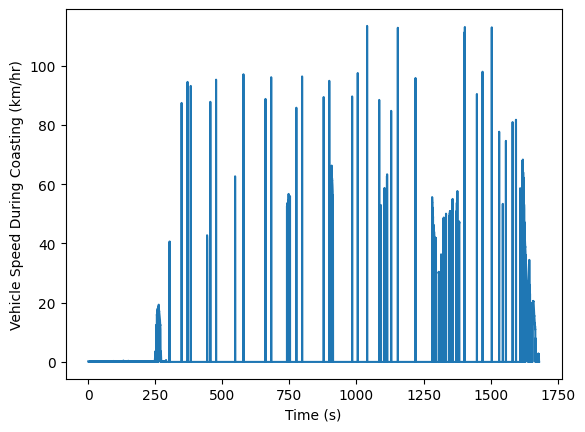

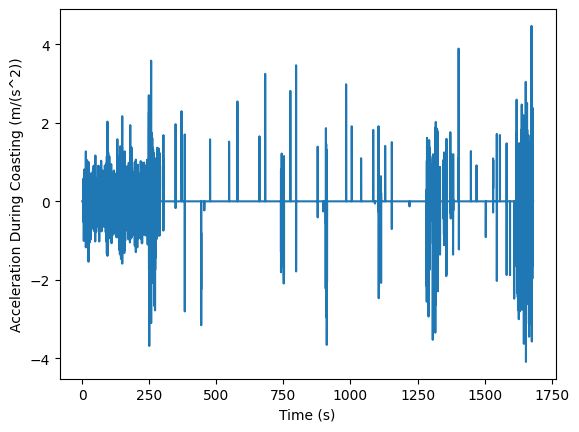

In [5]:
speed_during_coast = RACE_DATA_DF['GPS Speed'] * RACE_DATA_DF['GPS CST On']
plot_data(magnitude_of_df_col('Time'), f'Time ({UNITS["Time"]})', convert_to_magnitude(speed_during_coast, 'miles/hr'), 'Vehicle Speed During Coasting (km/hr)')

acceleration_during_coast = assign_df_units(assign_df_units(RACE_DATA_DF['GPS Speed'].diff().fillna(0), UNITS['GPS Speed']) * RACE_DATA_DF['GPS CST On'] / assign_df_units(RACE_DATA_DF['dT'].replace(0, np.nan), UNITS['dT']), 'm/(s^2)')
plot_data(magnitude_of_df_col('Time'), f'Time ({UNITS["Time"]})', convert_to_magnitude(acceleration_during_coast, 'm/(s^2)'), 'Acceleration During Coasting (m/(s^2))')